# Welcome to Homework #1: Robust ML!
In this homework assignment you will complete the following three tasks
1. Implement Empirical Risk Minimization
2. Implement GroupDRO Algorithm following the lecture. For more information you can look at the original paper:
 > [Sagawa, Shiori, et al. "Distributionally robust neural networks for group shifts: On the importance of regularization for worst-case generalization." International Conference on Learning Representations (ICLR), 2020.](https://arxiv.org/abs/1911.08731)
3. Fine-tune a pre-trained vision transformer
4. Compare robustness properties of the three approaches


##IMPORTANT:
  > Before you get started, select `Runtime > Change runtime type` and select `GPU` for your hardware accelerator.


##A couple of notes
1. Make sure to run each cell in order!
2. Only fill in code in sections marked as follows:
```
# <<<<<< Put your code here
# Write your code
# >>>>>
```

Let's get started!



## Environment Setup

First we have to install the `wilds` python package which will give us access to the Waterbirds dataset. Run the command and give it ~1 min to install.

In [1]:
%%capture
!pip install wilds

Now we load each of the packages we need for the worksheet. See the comments for the purpose of each

In [2]:
from wilds import get_dataset # Function to download wilds datasets
import torch # Pytorch library used for defining and training ML models
import torch.nn as nn # the nerual network library used for defining models
from torch.utils.data import DataLoader # Used for wrapping and iterating through out data
import torchvision # Package with utilities for computer vision such as pretrained models
import torchvision.transforms as transforms # Set of image transforms for processing image inputs

import numpy as np # Numpy used for general array manipulation
import matplotlib.pyplot as plt # Used for showing images
import pandas as pd # Used for storing our results

from tqdm import tqdm # Progress bar while training
import warnings # Give warnings, such as if CUDA is unavailable
import multiprocessing # Allows us to check the number of available CPUS

Now we check that GPU-support is available. If not, you may have forgotten to select the GPU hardware accelerator. We also set some useful constants.

In [3]:
if not torch.cuda.is_available():
    warnings.warn(
        "CUDA is not available, please check that you have selected a GPU for hardware acceleration"
    )

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_CORES = multiprocessing.cpu_count()

## Download and visualize the dataset

Next we will download and visualize the waterbirds dataset. The waterbirds dataset is a synthetic binary classification dataset where the goal is to predict if a bird is a "Landbird" or a "Waterbird". The birds have been placed on artificial backgrounds where roughly 95% of the time landbirds are against a land backdrop and waterbirds are against a water backdrop. The other 5% of the time landbirds are found over water and waterbirds are found on land. Each of the four confirgurations of "Landbird vs. Waterbird" and "over land vs. over water" makes up a subgroup. Let's begin!

Run the command below to download the waterbirds (should take 1-5 minutes to download). If your session stays active you won't need to re-download this each time you run it.

In [4]:
dataset = get_dataset(dataset="waterbirds", download=True)

You can also download the dataset manually at https://wilds.stanford.edu/downloads.


489291776Byte [01:02, 7777549.39Byte/s]


Extracting data/waterbirds_v1.0/archive.tar.gz to data/waterbirds_v1.0

It took 1.15 minutes to download and uncompress the dataset.



Now lets visualize one training example from each subgroup (remember to read the section above explaining what the four subgroups are)

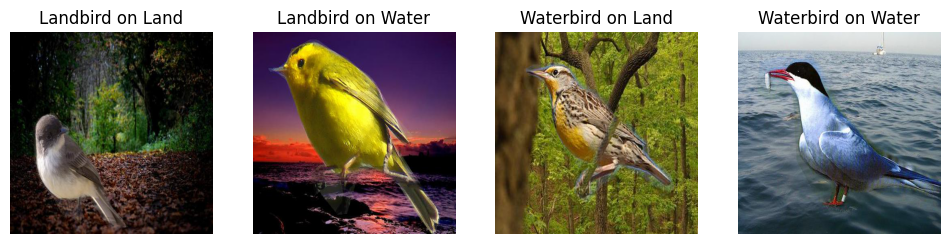

In [5]:
# Get the number of groups (should be 4)
n_groups = dataset._eval_grouper.n_groups

# Get a list of all the group ids for each data point in the dataset
group_ids = dataset._eval_grouper.metadata_to_group(dataset.metadata_array)

# Define the group and class labels
group_labels = ["Landbird on Land", "Landbird on Water", "Waterbird on Land", "Waterbird on Water"]
class_labels = ["Landbird", "Waterbird"]

# Sample one random image from each group
np.random.seed(2)
sample_images = [dataset[np.random.choice(np.where(group_ids == i)[0])][0] for i in range(n_groups)]

# Plot the figures with the group label as the title
fig, axs = plt.subplots(1, n_groups, figsize=(3*n_groups, 3))

for i in range(n_groups):
    axs[i].imshow(sample_images[i], extent=[0,1,0,1])
    axs[i].set_title(group_labels[i])
    axs[i].axis('off')

plt.subplots_adjust(wspace=0.2)
plt.show()

## Create Train, Val, Test Splits



We can use the built-in utilities from the `wilds` package, but to do so, we need to define the set of transforms which involves resizing, cropping and then converting the image to a tensor and then normalizing it so the inputs are roughly in the range `[-1, 1]`

In [6]:
# Define the set of transforms used in the original paper
data_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],),
    ]
)

# Built in subset utilities from "wilds"
train_data = dataset.get_subset("train", transform=data_transforms)
val_data = dataset.get_subset("val", transform=data_transforms)
test_data = dataset.get_subset("test", transform=data_transforms)

# Construct some noisy data (This is used in the later half of the homework)
noisy_transform = transforms.Compose([data_transforms, lambda tensor: tensor + torch.randn(tensor.size())])
noisy_val_data = dataset.get_subset("val", transform=noisy_transform)

Lets find out how many examples of each group are in our training sets

In [7]:
# Get the group id for each of the examples in each split
train_groups = dataset._eval_grouper.metadata_to_group(train_data.metadata_array)
val_groups = dataset._eval_grouper.metadata_to_group(val_data.metadata_array)
test_groups = dataset._eval_grouper.metadata_to_group(test_data.metadata_array)

# Count the number of examples of each group type
train_examples_per_group = [(train_groups == i).sum().item() for i in range(n_groups)]
val_examples_per_group = [(val_groups == i).sum().item() for i in range(n_groups)]
test_examples_per_group = [(test_groups == i).sum().item() for i in range(n_groups)]

# Store the results in a data frame to display
data_summary = pd.DataFrame(columns=[*group_labels, "Total"])
data_summary.loc[0] = [*train_examples_per_group, sum(train_examples_per_group)]
data_summary.loc[1] = [*val_examples_per_group, sum(val_examples_per_group)]
data_summary.loc[2] = [*test_examples_per_group, sum(test_examples_per_group)]
data_summary.index = ['Training Examples', 'Val Examples', 'Test Examples']
data_summary

,Landbird on Land,Landbird on Water,Waterbird on Land,Waterbird on Water,Total
Training Examples,3498,184,56,1057,4795
Val Examples,467,466,133,133,1199
Test Examples,2255,2255,642,642,5794


## Define our Model and the functions to evaluate it

This function loads a `resnet50` model from torchivsion and replaces the final classification layer with a new layer of the appropriate size. The waterbirds classification class is binary ("Landbird" or "waterbird") so we use two outputs.

In [8]:
def Resnet50(outputs=2):
    # Load a resent50 model with the default pre-trained weights
    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

    # Replace the Feature Classifier (fc) with a new linear layer with 2 output dimensions
    d = model.fc.in_features
    model.fc = nn.Linear(d, outputs)
    return model

This function computes the predictions of the model on the dataset. It returns the true labels, the predicted labels and the group id of each datapoint in the dataset

In [9]:
def get_predictions(model, dataset, batch_size=32):
    # Put the model on the target device
    model = model.to(DEVICE)

    # Construct a dataloader with the specified batch size
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=N_CORES)

    # Empty arrays for storing labels and predictions and groups
    ypred = []
    y = []
    group = []

    # Put the model in eval model and don't store gradients
    model.eval()
    with torch.no_grad():
        # Loop through all data in batches
        for inputs, labels, metadata in dataloader:
            groups = dataset.dataset._eval_grouper.metadata_to_group(metadata)
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Compute model outputs and  predictions
            outputs = model(inputs)
            predicted = torch.argmax(outputs.data, 1)

            # Store the results
            ypred.extend(predicted.cpu().numpy())
            y.extend(labels.cpu().numpy())
            group.extend(groups)

    return np.array(y), np.array(ypred), np.array(group)

This function uses the previous function and computes the per-group performance of the model on the provided dataset

In [10]:
def evaluate(model, dataset, batch_size=32):
    # Get the predictions
    y, ypred, group = get_predictions(model, dataset, batch_size)

    # Compute accuracy for each group
    accuracies = []
    for i in range(n_groups):
        group_indices = group == i
        group_y = y[group_indices]
        group_ypred = ypred[group_indices]
        accuracy = (group_y == group_ypred).mean()
        accuracies.append(accuracy)

    # Add the aggregate accuracy
    accuracies.append((y == ypred).mean())
    return accuracies


## Empirical Risk Minimization (ERM)

---
This is where we will begin our implementation, starting with the basic formulation of statistical machine learning: Empirical Risk Minimization.


This function trains a model using empirical risk minimization on the provided dataset

In [11]:
def train_ERM(
    model,
    dataset,
    batch_size=128,
    num_epochs=1,
    learning_rate=1e-3,
    weight_decay=1e-4,
):
    # Move the model to the device
    model = model.to(DEVICE)

    # <<<<<< Put your code here
    # Define the criterion to be used in the loss function [1 line]
    # Hint: you can find a list of loss functions here: https://pytorch.org/docs/stable/nn.html#loss-functions.

    criterion = nn.CrossEntropyLoss()

    # >>>>>

    # Define the optimizer
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay
    )

    # Construct the DataLoader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=N_CORES
    )

    # Construct the progess bar
    num_batches = len(dataloader)
    progress_bar = tqdm(
        total=num_batches * num_epochs, desc="Training Progress", position=0, leave=True
    )


    # Put the model into train mode
    model.train()

    # Loop over epochs
    for epoch in range(num_epochs):
        running_loss = 0.0

        # Loop over data
        for (i, (inputs, labels, _)) in enumerate(dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # <<<<<< Put your code here
            # Zero the gradients in the optimizezr [1 line]
            optimizer.zero_grad()

            # Compute the model outputs [1 line]
            pred_labels = model(inputs)

            # compute the loss according the criterion [1 line)
            # NOTE: Please keep this variable named "loss" as it is used later on to keep track of the running loss
            loss = criterion(pred_labels, labels)

            # Compute gradients of the loss and step the optimizer [2 lines]
            loss.backward()
            optimizer.step()
            # >>>>>

            # Accumlate the running loss and update the progress bar
            running_loss += loss.item()
            progress_bar.update(1)
            progress_bar.set_postfix({'Epoch': epoch+1, 'Batch': i+1, 'Train_Loss': running_loss / (i+1)})

    progress_bar.close()

Let's train our first model!
This should take about 1 min

In [12]:
ERM_resnet = Resnet50()
train_ERM(ERM_resnet, train_data)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.4MB/s]
Training Progress: 100%|██████████| 38/38 [00:54<00:00,  1.43s/it, Epoch=1, Batch=38, Train_Loss=0.469]


Now that we have trained our model, let's evaluate it on the validation set to see how well we did

In [13]:
ERM_resnet_val_accuracies = evaluate(ERM_resnet, val_data)
ERM_resnet_noisy_val_accuracies = evaluate(ERM_resnet, noisy_val_data) # For later

Store the results in a table that we will re-use

In [14]:
results = pd.DataFrame(columns=[*group_labels, "Aggregate"])
results.loc[0] = ERM_resnet_val_accuracies
results.rename(index={0: 'ERM - ResNet - Val'}, inplace=True)
results

,Landbird on Land,Landbird on Water,Waterbird on Land,Waterbird on Water,Aggregate
ERM - ResNet - Val,1.0,0.856223,0.045113,0.578947,0.791493


In [15]:
torch.save(ERM_resnet, "ERM_resnet.ckpt")


Clear the GPU memory so we can train a new model next

In [44]:
del ERM_resnet
torch.cuda.empty_cache()

NameError: ignored

## Group Distributionally Robust Optimization (GroupDRO)

In [45]:
torch.cuda.empty_cache()

In [46]:
def train_GroupDRO(
    model,
    dataset,
    batch_size=128,
    num_epochs=1,
    learning_rate=1e-3,
    weight_decay=1e-4,
    step_size=0.01 # This is \eta_q from the slides
):
    # Move the model to the device
    model = model.to(DEVICE)

    # <<<<<< Put your code here
    # Define the criterion to be used in the loss function [1 line]
    criterion = nn.CrossEntropyLoss()
    # >>>>>

    # Define the optimizer
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay
    )

    # Construct the DataLoader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=N_CORES
    )

    # Construct the progess bar
    num_batches = len(dataloader)
    progress_bar = tqdm(
        total=num_batches * num_epochs, desc="Training Progress", position=0, leave=True
    )


    # Put the model into train mode
    model.train()

    # <<<<<< Put your code here
    # Initialize group weights to all ones [1 line]
    # Hint: to get the number of groups use the varialbe "n_groups" which we defined when we loaded in the dataset.
    group_weights = torch.ones((n_groups), device=DEVICE)
    # >>>>>

    # Loop over epochs
    for epoch in range(num_epochs):
        running_loss = 0.0

        # Loop over data
        for (i, (inputs, labels, metadata)) in enumerate(dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            groups = dataset.dataset._eval_grouper.metadata_to_group(metadata) # (batch_size,)

            # <<<<<< Put your code here
            # Zero the gradients in the optimizezr [1 line]
            optimizer.zero_grad()
            # Compute the model outputs [1 line]
            pred_labels = model(inputs)
            # Calculate per-group losses [~5 lines]
            # Hint: Iterate over the group ids and compute the loss for all inputs that match the group. The "groups" variable defined above may be helpful.
            group_losses = torch.zeros((n_groups), device=DEVICE)
            for i, group in enumerate(groups):
              group_losses[group] += criterion(pred_labels[i][None], labels[i][None])

            # Update the group weights and normalize them [2 lines]
            # Hint: The variable step_size provided as input to the function is the same as \eta_q in the slides. Use it here.
            group_weights = group_weights * group_losses.exp() * step_size
            group_weights = group_weights / group_weights.sum()

            # Compute the weighted average of per-group losses [1 line]
            # NOTE: Please keep this variable named "weighted_loss" as it is used later on to keep track of the running loss
            weighted_loss = group_weights * group_losses

            # Compute gradients of the loss and step the optimizer [2 lines]
            weighted_loss.backward()
            optimizer.step()
            # >>>>>

            # Accumlate the running loss and update the progress bar
            running_loss += weighted_loss.item()
            progress_bar.update(1)
            progress_bar.set_postfix({'Epoch': epoch+1, 'Batch': i+1, 'Train_Loss': running_loss / (i+1)})

    progress_bar.close()

Train the GroupDRO ResNet50 Model (~1 min)

In [ ]:
GroupDRO_resnet = Resnet50()
DEVICE=torch.device("cpu")
train_GroupDRO(GroupDRO_resnet, train_data)

Training Progress:   0%|          | 0/38 [00:00<?, ?it/s]

In [ ]:
from google.colab import files
torch.save(GroupDRO_resnet, "GroupDRO_resnet.ckpt")
files.download( "GroupDRO_resnet.ckpt" )

Evaluate the GroupDRO model on the validation set

In [ ]:
GroupDRO_resnet_val_accuracies = evaluate(GroupDRO_resnet, val_data)
GroupDRO_resnet_noisy_val_accuracies = evaluate(GroupDRO_resnet, noisy_val_data) # For later

Store the results in our table

In [ ]:
results.loc[1] = GroupDRO_resnet_val_accuracies
results.rename(index={1: 'GroupDRO - ResNet - Val'}, inplace=True)
results

How does GroupDRO compare to ERM?

Clear the GPU memory so we can train a new model next

In [ ]:
del GroupDRO_resnet
torch.cuda.empty_cache()

## Fine-Tuning a Vision Transformer

This function will return a Vision Transformer that is ready to be fine-tuned. It should be intitialized with the default set of weights.

To enable fine-tuning we will freeze all but the final layer

In [ ]:
def ViT(output=2):
    # <<<<<< Put your code here
    # Load vit_b_16 torchvision model with weights=torchvision.models.ViT_B_16_Weights.DEFAULT

    # Disable all of the gradients for all parameters [2 lines]

    # Replace the last "head" with a new linear layer of the appropriate size [~2 lines]
    # HINT: The last layer is in list called "heads".
    # HINT: Refer to the ResNet50() function above to see how to make a new layer

    # >>>>>

    return model

Train a ViT using ERM and evaluate (~2-3 min)

In [ ]:
ERM_vit = ViT()
train_ERM(ERM_vit, train_data)
ERM_vit_val_accuracies = evaluate(ERM_vit, val_data)
ERM_vit_noisy_val_accuracies = evaluate(ERM_vit, noisy_val_data)
del ERM_vit
torch.cuda.empty_cache()

Train a ViT using GroupDRO and evaluate  (~2-3 min)

In [ ]:
GroupDRO_vit = ViT()
train_GroupDRO(GroupDRO_vit, train_data)
GroupDRO_vit_val_accuracies = evaluate(GroupDRO_vit, val_data)
GroupDRO_vit_noisy_val_accuracies = evaluate(GroupDRO_vit, noisy_val_data)
del GroupDRO_vit
torch.cuda.empty_cache()

In [ ]:
results.loc[2] = ERM_vit_val_accuracies
results.loc[3] = GroupDRO_vit_val_accuracies
results.rename(index={2: 'ERM - ViT - Val'}, inplace=True)
results.rename(index={3: 'GroupDRO - ViT - Val'}, inplace=True)
results

## Robustness to Noise

In addition to evaluating on the validation set, we created a "noisy" validation set that included Gaussian noise on the inputs.

An example of Gaussian noise is below
![](https://www.researchgate.net/publication/221913964/figure/fig7/AS:305170975084549@1449769838319/Examples-of-images-modified-by-Gaussian-noise-Gaussian-noise-was-applied-on-each-image.png)

In general, a model's performance will drop due to this perturbation, but a robust model will retain its performance better. Let's see how the different model architecture compare

In [ ]:
noisy_results = pd.DataFrame(columns=["Clean Accuracy", "Noisy Accuracy"])
noisy_results.loc[0] = [GroupDRO_resnet_val_accuracies[-1], GroupDRO_resnet_noisy_val_accuracies[-1]]
noisy_results.loc[1] = [GroupDRO_vit_val_accuracies[-1], GroupDRO_vit_noisy_val_accuracies[-1]]
noisy_results.rename(index={0: 'DRO - ResNet'}, inplace=True)
noisy_results.rename(index={1: 'DRO - ViT'}, inplace=True)
noisy_results

Does the pre-trained ViT improve robustness to noise?

## Conclusion and Bonus Activities


---



Congratulations on completing the assignment! You can stop here, or if you want to try out some additional concepts from lecture consider trying one of the following


1. Experiment with other architectures and pre-training types. You can find a list of pre-trained models [here](https://pytorch.org/vision/stable/models.html)
2. Experiment with robustness to other types of transformations, or try augmentating your training data with them. Available transforms in torchvision are [here](https://pytorch.org/vision/main/transforms.html)
3. Implement DeepCORAL [paper](https://arxiv.org/abs/1607.01719), [sample code](https://github.com/DenisDsh/PyTorch-Deep-CORAL)   

